# ResNet-50 Training on Critter Capture

Train a ResNet-50 classifier on the cached observation images and CSV metadata.


## Notebook Overview

- Load the observations CSV and align it with images cached in `data/raw/images`.
- Prepare stratified train/validation/test splits and construct PyTorch datasets.
- Configure a ResNet-50 model, optimizer, scheduler, and class-balanced loss.
- Run the training loop with mixed precision and evaluate on the hold-out split.


In [1]:
import math
import random
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18
from tqdm.auto import tqdm


/home/public/avaishna2/critter-capture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Project paths and reproducibility helpers
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
CSV_PATH = DATA_DIR / "data.csv"
IMAGE_DIR = DATA_DIR / "raw" / "images"

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found at {CSV_PATH}")
if not IMAGE_DIR.exists():
    raise FileNotFoundError(
        f"Expected image directory at {IMAGE_DIR}. Run the data ingestion step first."
    )

SEED = 42


def set_seed(seed: int) -> None:
    # Seed all common random number generators for reproducibility.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(SEED)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=1)

In [3]:
config = {
    "data": {
        "validation_size": 0.15,
        "test_size": 0.15,
        "image_size": 224,
        "normalize_mean": [0.485, 0.456, 0.406],
        "normalize_std": [0.229, 0.224, 0.225],
        "num_workers": 4,
    },
    "training": {
        "epochs": 20,
        "batch_size": 512,
        "learning_rate": 5e-4,
        "weight_decay": 0.01,
        "gradient_clip_norm": 1.0,
        "early_stopping_patience": 5,
        "amp": True,
        "scheduler": {
            "t_max": 10,
            "min_lr": 1e-6,
        },
    },
}
config


{'data': {'validation_size': 0.15,
  'test_size': 0.15,
  'image_size': 224,
  'normalize_mean': [0.485, 0.456, 0.406],
  'normalize_std': [0.229, 0.224, 0.225],
  'num_workers': 4},
 'training': {'epochs': 20,
  'batch_size': 512,
  'learning_rate': 0.0005,
  'weight_decay': 0.01,
  'gradient_clip_norm': 1.0,
  'early_stopping_patience': 5,
  'amp': True,
  'scheduler': {'t_max': 10, 'min_lr': 1e-06}}}

In [4]:
df = pd.read_csv(CSV_PATH)
required_cols = {"uuid", "taxon_id", "common_name"}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"CSV is missing columns: {missing_cols}")

df = df.dropna(subset=["uuid", "taxon_id", "common_name"])
df["uuid"] = df["uuid"].astype(str)
df["taxon_id"] = df["taxon_id"].astype(int)

val_test_size = config["data"]["validation_size"] + config["data"]["test_size"]
min_class_frequency = 2
if val_test_size > 0:
    min_class_frequency = max(min_class_frequency, int(math.ceil(2.0 / val_test_size)))
class_counts = df["taxon_id"].value_counts()
rare_taxa = class_counts[class_counts < min_class_frequency].index.tolist()
if rare_taxa:
    print(
        f"Filtering out {len(rare_taxa)} classes with fewer than {min_class_frequency} samples."
    )
    df = df[~df["taxon_id"].isin(rare_taxa)].reset_index(drop=True)

if df.empty:
    raise RuntimeError(
        "No observations remain after filtering low-frequency classes. Adjust the threshold."
    )

label_lookup = (
    df[["taxon_id", "common_name"]]
    .drop_duplicates(subset=["taxon_id"])
    .set_index("taxon_id")["common_name"]
    .to_dict()
)

sorted_label_ids = sorted(label_lookup.keys())
id_to_index = {label_id: idx for idx, label_id in enumerate(sorted_label_ids)}
index_to_name = [label_lookup[label_id] for label_id in sorted_label_ids]

df["label_index"] = df["taxon_id"].map(id_to_index)

df["image_path"] = df["uuid"].apply(lambda uuid: IMAGE_DIR / f"{uuid}.jpg")
available_mask = df["image_path"].apply(lambda path: path.exists())

missing_count = (~available_mask).sum()
if missing_count:
    print(
        f"Warning: {missing_count} images are missing from {IMAGE_DIR}. They will be skipped."
    )

df = df[available_mask].reset_index(drop=True)

if df.empty:
    raise RuntimeError(
        "No images were found in the cache. Populate data/raw/images before training."
    )

print(
    f"Loaded {len(df)} records across {df['label_index'].nunique()} classes after filtering."
)


Filtering out 453 classes with fewer than 7 samples.
Loaded 104547 records across 444 classes after filtering.


In [5]:
val_size = config["data"]["validation_size"]
test_size = config["data"]["test_size"]
val_test_size = val_size + test_size
if val_test_size <= 0 or val_test_size >= 1:
    raise ValueError("Validation and test sizes must sum to a value between 0 and 1.")

train_df, temp_df = train_test_split(
    df,
    test_size=val_test_size,
    stratify=df["label_index"],
    random_state=SEED,
)

temp_counts = temp_df["label_index"].value_counts()
too_small = temp_counts[temp_counts < 2].index.tolist()
if too_small:
    print(
        "Reassigning hold-out samples for classes with fewer than 2 instances to the training split."
    )
    move_mask = temp_df["label_index"].isin(too_small)
    train_df = pd.concat([train_df, temp_df[move_mask]], ignore_index=True)
    temp_df = temp_df[~move_mask].reset_index(drop=True)

if temp_df.empty:
    raise RuntimeError(
        "Hold-out split is empty after rebalancing. Reduce validation/test sizes or relax filtering."
    )

test_fraction = test_size / val_test_size
val_df, test_df = train_test_split(
    temp_df,
    test_size=test_fraction,
    stratify=temp_df["label_index"],
    random_state=SEED,
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Reassigning hold-out samples for classes with fewer than 2 instances to the training split.
Train: 73191 | Val: 15678 | Test: 15678


In [ ]:
class LocalObservationDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform, label_names):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform
        self.label_names = label_names

    def __len__(self) -> int:
        return len(self.frame)

    def __getitem__(self, idx: int):
        row = self.frame.iloc[idx]
        image_path = row["image_path"]
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError as exc:
            raise FileNotFoundError(f"Image missing at {image_path}") from exc

        if self.transform is not None:
            image = self.transform(image)

        target = torch.tensor(row["label_index"], dtype=torch.long)
        return {
            "image": image,
            "target": target,
        }


In [7]:
image_size = config["data"]["image_size"]
normalize_mean = config["data"]["normalize_mean"]
normalize_std = config["data"]["normalize_std"]

train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=normalize_mean, std=normalize_std),
    ]
)

eval_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=normalize_mean, std=normalize_std),
    ]
)


In [8]:
train_dataset = LocalObservationDataset(train_df, train_transforms, index_to_name)
val_dataset = LocalObservationDataset(val_df, eval_transforms, index_to_name)
test_dataset = LocalObservationDataset(test_df, eval_transforms, index_to_name)


def compute_class_weights(frame: pd.DataFrame, num_classes: int) -> torch.Tensor:
    counts = Counter(frame["label_index"].tolist())
    total = sum(counts.values())
    weights = torch.ones(num_classes, dtype=torch.float32)
    for idx, count in counts.items():
        weights[idx] = total / (num_classes * count)
    weights = weights / weights.mean()
    return weights


class_weights = compute_class_weights(train_df, len(index_to_name))

num_workers = config["data"]["num_workers"]
pin_memory = device.type == "cuda"

train_loader = DataLoader(
    train_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0,
)

len(train_dataset), len(val_dataset), len(test_dataset)


(73191, 15678, 15678)

Data shape: torch.Size([512, 3, 224, 224]), Target shape: torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.4110641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7731092..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.141793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5952941..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
C

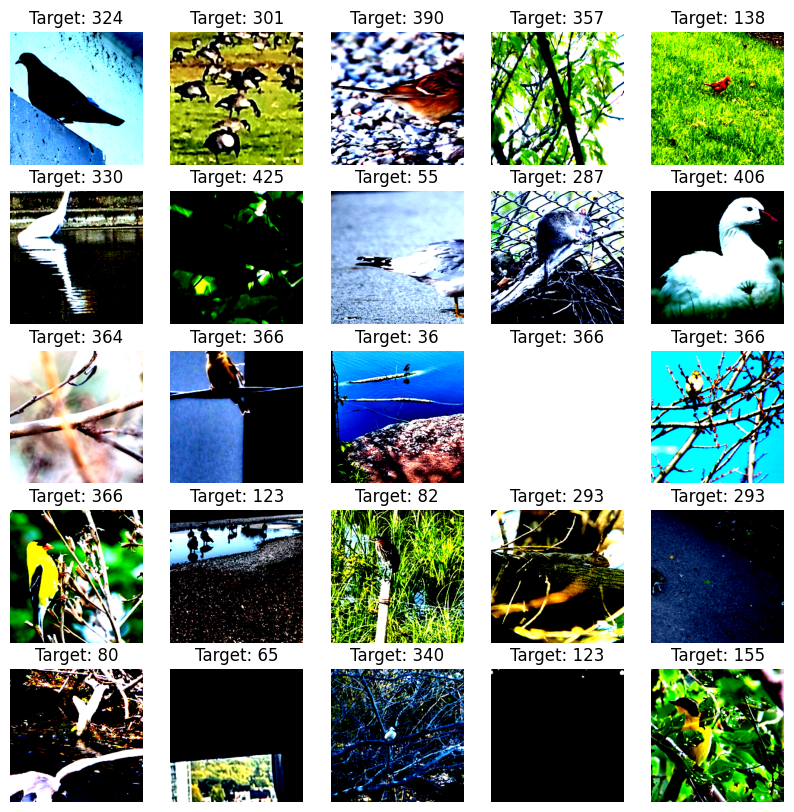

In [13]:
from matplotlib import pyplot as plt

data = next(iter(train_loader))
print(f"Data shape: {data['image'].shape}, Target shape: {data['target'].shape}")

# show the image and the target for the first batch in a grid of 5x5
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    image = data["image"][i].cpu().permute(1, 2, 0).numpy()
    axes[i // 5, i % 5].imshow(image)
    axes[i // 5, i % 5].set_title(f"Target: {data['target'][i].item()}")
    axes[i // 5, i % 5].axis("off")
plt.show()


In [14]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(index_to_name))
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["training"]["learning_rate"],
    weight_decay=config["training"]["weight_decay"],
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["training"]["learning_rate"],
    total_steps=config["training"]["epochs"] * len(train_loader),
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/noncs/temp/avaishna/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s] 


In [15]:
def train_one_epoch(
    model,
    dataloader,
    optimizer,
    criterion,
    device,
    scaler,
    grad_clip,
    use_amp,
):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    all_targets = []

    progress = tqdm(dataloader, desc="train")
    for batch in progress:
        images = batch["image"].to(device)
        targets = batch["target"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device.type):
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()

        if grad_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * targets.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

        progress.set_postfix(
            loss=running_loss / max(total, 1),
            acc=correct / max(total, 1),
        )

    history = {
        "loss": running_loss / max(total, 1),
        "accuracy": correct / max(total, 1),
    }

    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    history.update({"precision": precision, "recall": recall, "f1": f1})
    return history


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    all_targets = []

    for batch in tqdm(dataloader, desc="eval", leave=False):
        images = batch["image"].to(device)
        targets = batch["target"].to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * targets.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

    history = {
        "loss": running_loss / max(total, 1),
        "accuracy": correct / max(total, 1),
    }

    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    history.update({"precision": precision, "recall": recall, "f1": f1})
    return history


In [ ]:
def train_model(
    model, train_loader, val_loader, optimizer, scheduler, criterion, config, device
):
    num_epochs = config["training"]["epochs"]
    patience = config["training"]["early_stopping_patience"]
    use_amp = config["training"]["amp"] and device.type == "cuda"
    grad_clip = config["training"]["gradient_clip_norm"]

    scaler = torch.amp.GradScaler(enabled=use_amp)
    best_state = None
    best_metric = -math.inf
    patience_counter = 0
    history = []

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        train_metrics = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            device,
            scaler,
            grad_clip,
            use_amp,
        )
        val_metrics = evaluate(model, val_loader, criterion, device)
        print(f"train metrics: {train_metrics}")
        print(f"val metrics: {val_metrics}")

        if scheduler is not None:
            scheduler.step()

        history.append(
            {
                "epoch": epoch,
                "train": train_metrics,
                "val": val_metrics,
            }
        )

        val_score = val_metrics["accuracy"]
        if val_score > best_metric:
            best_metric = val_score
            best_state = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict() if scheduler is not None else None,
                "epoch": epoch,
                "config": config,
                "label_names": index_to_name,
            }
            patience_counter = 0
            print(f"New best validation accuracy: {best_metric:.4f}")
        else:
            patience_counter += 1
            print(
                f"Validation accuracy did not improve. Patience {patience_counter}/{patience}."
            )
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return best_state, history


In [17]:
best_checkpoint, training_history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    config,
    device,
)


Epoch 1/20


train: 100%|██████████| 143/143 [01:23<00:00,  1.71it/s, acc=0.00187, loss=6.17]


New best validation accuracy: 0.0050
Epoch 2/20


train: 100%|██████████| 143/143 [01:25<00:00,  1.66it/s, acc=0.0141, loss=5.81]


New best validation accuracy: 0.0323
Epoch 3/20


train: 100%|██████████| 143/143 [01:26<00:00,  1.65it/s, acc=0.0443, loss=5.49]


New best validation accuracy: 0.0705
Epoch 4/20


train: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s, acc=0.0768, loss=5.19]


New best validation accuracy: 0.1036
Epoch 5/20


train: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s, acc=0.101, loss=4.95] 


New best validation accuracy: 0.1287
Epoch 6/20


train: 100%|██████████| 143/143 [01:28<00:00,  1.61it/s, acc=0.123, loss=4.72]


New best validation accuracy: 0.1503
Epoch 7/20


train: 100%|██████████| 143/143 [01:26<00:00,  1.64it/s, acc=0.139, loss=4.52]


New best validation accuracy: 0.1646
Epoch 8/20


train: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s, acc=0.154, loss=4.36]


New best validation accuracy: 0.1807
Epoch 9/20


train: 100%|██████████| 143/143 [01:24<00:00,  1.69it/s, acc=0.17, loss=4.21] 


New best validation accuracy: 0.2013
Epoch 10/20


train: 100%|██████████| 143/143 [01:30<00:00,  1.58it/s, acc=0.184, loss=4.07]


New best validation accuracy: 0.2165
Epoch 11/20


train: 100%|██████████| 143/143 [01:31<00:00,  1.56it/s, acc=0.199, loss=3.93]


New best validation accuracy: 0.2268
Epoch 12/20


train: 100%|██████████| 143/143 [01:31<00:00,  1.57it/s, acc=0.209, loss=3.82]


New best validation accuracy: 0.2390
Epoch 13/20


train: 100%|██████████| 143/143 [01:25<00:00,  1.68it/s, acc=0.222, loss=3.72]


New best validation accuracy: 0.2537
Epoch 14/20


train: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s, acc=0.234, loss=3.6] 


New best validation accuracy: 0.2660
Epoch 15/20


train: 100%|██████████| 143/143 [01:24<00:00,  1.70it/s, acc=0.245, loss=3.5] 


New best validation accuracy: 0.2780
Epoch 16/20


train: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s, acc=0.254, loss=3.41]


New best validation accuracy: 0.2876
Epoch 17/20


train: 100%|██████████| 143/143 [01:26<00:00,  1.65it/s, acc=0.261, loss=3.28]


New best validation accuracy: 0.2963
Epoch 18/20


train: 100%|██████████| 143/143 [01:24<00:00,  1.69it/s, acc=0.271, loss=3.22]


New best validation accuracy: 0.3038
Epoch 19/20


train: 100%|██████████| 143/143 [01:24<00:00,  1.70it/s, acc=0.278, loss=3.14]


New best validation accuracy: 0.3097
Epoch 20/20


train: 100%|██████████| 143/143 [01:28<00:00,  1.62it/s, acc=0.287, loss=3.06]
                                                     

New best validation accuracy: 0.3165


In [19]:
training_history

[{'epoch': 1,
  'train': {'loss': 6.170291438632193,
   'accuracy': 0.001871814840622481,
   'precision': 0.004899789158873625,
   'recall': 0.00400291373800123,
   'f1': 0.001174303107268876},
  'val': {'loss': 5.9624321889871235,
   'accuracy': 0.005038908023982651,
   'precision': 0.009941188169414859,
   'recall': 0.012214776651707572,
   'f1': 0.003215667946730846}},
 {'epoch': 2,
  'train': {'loss': 5.813134925253488,
   'accuracy': 0.014072768509789455,
   'precision': 0.018735012669719074,
   'recall': 0.02217725490553091,
   'f1': 0.008698995959316811},
  'val': {'loss': 5.6551597816388455,
   'accuracy': 0.03233830845771144,
   'precision': 0.028827383165258708,
   'recall': 0.04764344496858203,
   'f1': 0.01842334160845934}},
 {'epoch': 3,
  'train': {'loss': 5.491735800123282,
   'accuracy': 0.04430872648276427,
   'precision': 0.03940529501350183,
   'recall': 0.06566252731416482,
   'f1': 0.025740259406904713},
  'val': {'loss': 5.351634340910358,
   'accuracy': 0.0705447

In [ ]:
train_loss = [item["train"]["loss"] for item in training_history]
val_loss = [item["val"]["loss"] for item in training_history]
train_acc = [item["train"]["accuracy"] for item in training_history]
val_acc = [item["val"]["accuracy"] for item in training_history]


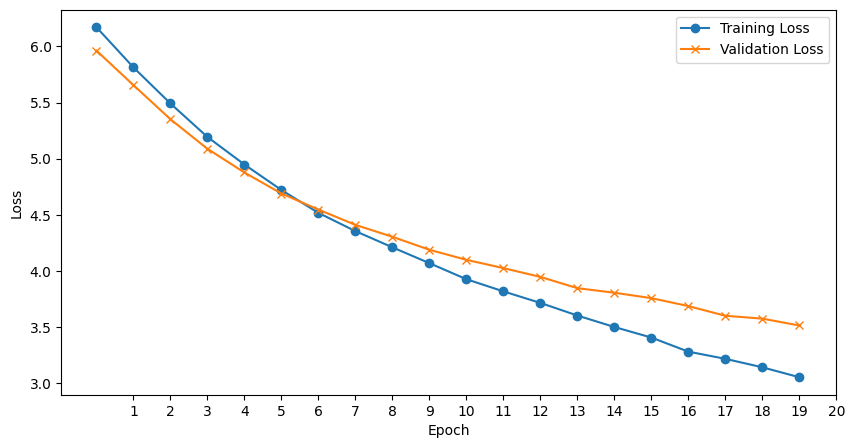

In [ ]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(val_loss, label="Validation Loss", marker="x")
plt.xticks(range(1, config["training"]["epochs"] + 1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

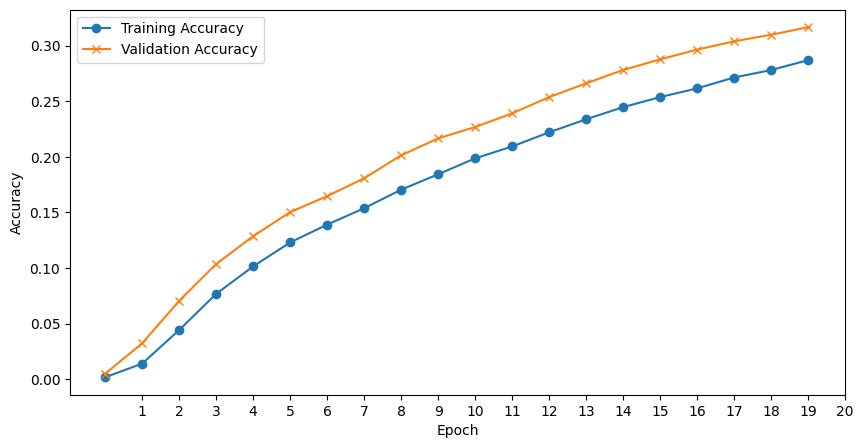

In [ ]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Training Accuracy", marker="o")
plt.plot(val_acc, label="Validation Accuracy", marker="x")
plt.xticks(range(1, config["training"]["epochs"] + 1))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [27]:
if best_checkpoint is not None:
    model.load_state_dict(best_checkpoint["model"])
    test_metrics = evaluate(model, test_loader, criterion, device)
    print("Test metrics:", test_metrics)
else:
    print("Training did not produce a checkpoint. Check earlier logs for issues.")


Test metrics: {'loss': 3.513925616755475, 'accuracy': 0.3166220181145554, 'precision': 0.20124224837025667, 'recall': 0.30197185834478163, 'f1': 0.1947013257059597}


In [29]:
if best_checkpoint is not None:
    history_records = []
    for item in training_history:
        epoch_record = {"epoch": item["epoch"]}
        epoch_record.update({f"train_{k}": v for k, v in item["train"].items()})
        epoch_record.update({f"val_{k}": v for k, v in item["val"].items()})
        history_records.append(epoch_record)

history_df = pd.DataFrame(history_records)
history_df


,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,val_loss,val_accuracy,val_precision,val_recall,val_f1
0,1,6.170291,0.001872,0.004900,0.004003,0.001174,5.962432,0.005039,0.009941,0.012215,0.003216
1,2,5.813135,0.014073,0.018735,0.022177,0.008699,5.655160,0.032338,0.028827,0.047643,0.018423
2,3,5.491736,0.044309,0.039405,0.065663,0.025740,5.351634,0.070545,0.055023,0.089453,0.036237
3,4,5.193733,0.076772,0.058839,0.106640,0.042024,5.088459,0.103585,0.066013,0.114419,0.047665
4,5,4.948248,0.101488,0.071191,0.146861,0.055907,4.877442,0.128652,0.079135,0.133459,0.061950
5,6,4.721637,0.123048,0.086634,0.183614,0.070891,4.690248,0.150274,0.091604,0.149319,0.070870
6,7,4.518047,0.139020,0.100537,0.211248,0.082627,4.547377,0.164626,0.100903,0.167579,0.082972
7,8,4.355566,0.153789,0.114764,0.238506,0.097274,4.411422,0.180699,0.112504,0.188195,0.094812
8,9,4.211483,0.170417,0.128958,0.263158,0.111083,4.305047,0.201301,0.121619,0.199142,0.106566
9,10,4.070483,0.184312,0.136485,0.282228,0.122994,4.189636,0.216545,0.130637,0.219579,0.118113


In [ ]:
if best_checkpoint is not None:
    output_dir = PROJECT_ROOT / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = output_dir / "resnet18_best.pth"
    torch.save(best_checkpoint, checkpoint_path)
    checkpoint_path
